In [1]:
import os, sys
import sentencepiece
import numpy as np
from matplotlib import pyplot as plt

os.chdir('..')
sys.path.append(os.path.realpath('examples'))

In [2]:
wikitext_dir = '/tmp/wikitext-2-raw/'
tokens_out_fn = 'notebooks/data/wikitest-2-tknz.npz'
tokenizer = sentencepiece.SentencePieceProcessor('models/tokenizer.model', add_bos=True, num_threads=12)

if not os.path.exists(tokens_out_fn):
    tokens = []
    for fn in os.listdir(wikitext_dir):
        print(fn)
        with open(os.path.join(wikitext_dir, fn), 'rb') as f:
            tokens.extend(tokenizer.encode_as_ids(f.read()))
    tokens = np.asarray(tokens, dtype=np.uint16)
    np.savez(tokens_out_fn, tokens)
else:
    tokens = np.load(tokens_out_fn)['tokens']
    
token_id_max = tokens.max()
counts = np.zeros(token_id_max+1, dtype=np.uint)
np.add.at(counts, tokens, 1)

# Zipf model

In [3]:
orderby_counts_asc = np.argsort(counts)

counts_asc = counts[orderby_counts_asc]
n_dropped = np.searchsorted(counts_asc, 100)
counts_asc = counts_asc[n_dropped:]

toks_ids = orderby_counts_asc[n_dropped:][::-1]
tok_scores = np.fromiter((tokenizer.get_score(i) for i in range(len(counts))), dtype=float)
tok_ranks = -tok_scores[toks_ids]
m = tok_ranks <= 25000
m &= tok_ranks > 0
tok_ranks = tok_ranks[m]

toks_ids = toks_ids[m]
freqs = counts_asc[::-1][m]
probs = freqs / freqs.sum()
ranks = np.arange(1, len(probs)+1)

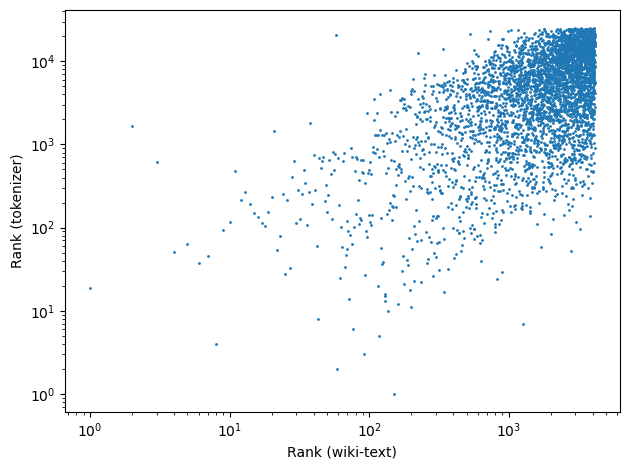

In [4]:
f, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Rank (wiki-text)')
ax.set_ylabel('Rank (tokenizer)')
ax.scatter(ranks,tok_ranks, s=1);
f.savefig('notebooks/figs/ranks-wiki-tokenizer.png')

In [5]:
from scipy.optimize import minimize_scalar, minimize
def fit_zipf(ranks, counts):
    H = lambda s: (np.arange(1, ranks.max() + 1) ** (-s)).sum()
    N = counts.sum()
    def neg_zipf_likelihood(s):
        return s * (counts * np.log(ranks)).sum() + N*np.log(H(s))
    res =  minimize_scalar(neg_zipf_likelihood)
    s = res.x
    denom = H(s)
    predicted = ranks**(-s) / denom
    return res.x, -res.fun, predicted, denom

s=0.9149806956848278 likelihood=-16879726.393141292


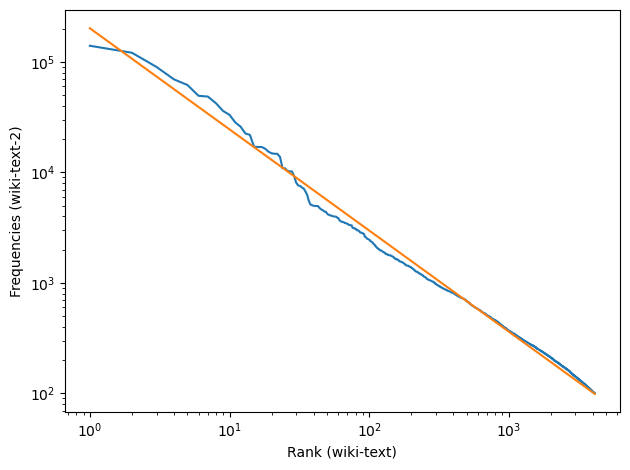

In [6]:
s, likelihood, predicted, denom = fit_zipf(ranks, freqs)
print(f'{s=} {likelihood=}')

f, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Rank (wiki-text)')
ax.set_ylabel('Frequencies (wiki-text-2)')
ax.plot(ranks, freqs);
ax.plot(ranks[::32], predicted[::32]*freqs.sum());
f.savefig('notebooks/figs/zipf-wiki.png')

s=0.8367672706442051 likelihood=-21773377.230541285


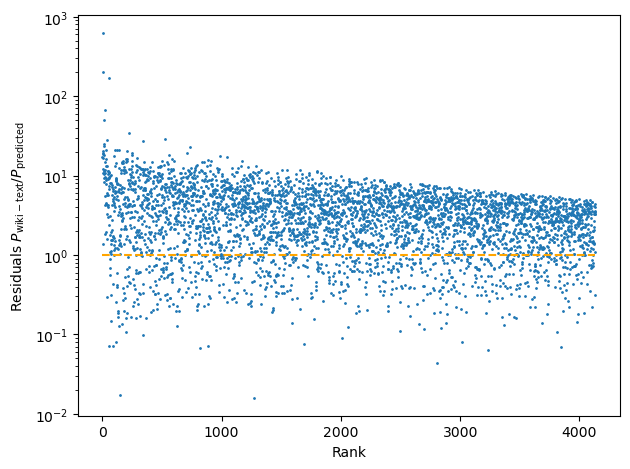

In [7]:
s, likelihood, predicted, denom = fit_zipf(tok_ranks, freqs)
print(f'{s=} {likelihood=}')
H = lambda s,n: (np.arange(1,n+1) ** (-s)).sum()

f, ax = plt.subplots()
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Rank')
ax.set_ylabel('Residuals $P_\mathrm{wiki-text}/P_\mathrm{predicted}$')

ax.scatter(ranks, probs / (tok_ranks**(-s) / denom), s=1);
ax.plot(ranks[::32], probs[::32]/probs[::32], '--', color='orange')
#ax.scatter(probs, tok_ranks**(-s) / H(s, len(ts)), s=1);
f.savefig('notebooks/figs/residuals.png')

In [8]:
H = lambda s,n: (np.arange(1,n+1) ** (-s)).sum()
ts = -tok_scores
m = (ts > 0) & (ts <= len(tok_scores)+1)
ts = ts[m]
(
    s,
    H(s, ts.max()),
    (ts ** (-s) / H(s, ts.max())).sum(),
)

(0.8367672706442051, 27.70366018533427, 0.9907420308243023)

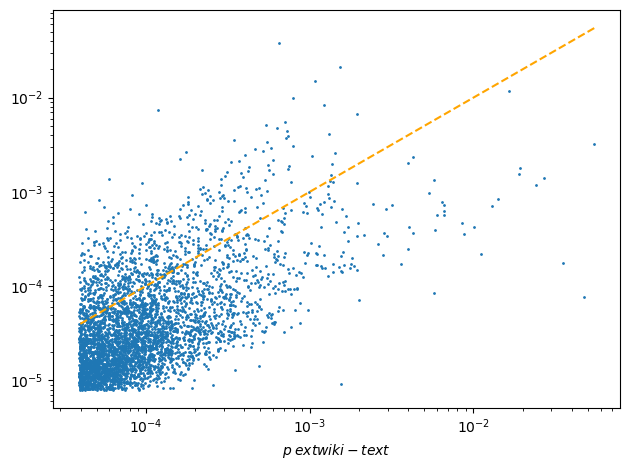

In [9]:
f, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Rank (tokenizer)')
ax.set_xlabel('$p_\text{wiki-text}$')

ax.scatter(probs, tok_ranks**(-s) / denom, s=1);
ax.plot(probs[::32], probs[::32], '--', color='orange')
f.savefig('notebooks/figs/predict-rank-probs.png');

In [10]:
' '.join(tokenizer.id_to_piece(int(tok)) for tok in toks_ids[:50])

'▁the ▁, ▁. ▁of ▁and ▁in ▁to ▁a ▁= ▁" ▁@ ▁was ▁\' ▁The ▁as ▁that ▁on ▁for ▁with ▁by ▁) ▁( ▁is ▁from ed ▁at ing ▁his ▁were ▁it ▁he ▁an ▁In ▁had ▁which ▁be ▁are ▁; ▁not ▁their ▁but ▁A es ▁first ▁– ▁also ▁its ▁or ▁: ers'

In [11]:
' '.join(tokenizer.id_to_piece(int(tok)) for tok in toks_ids[np.argsort(tok_ranks)][:50])

'▁t er in ▁a en on ▁th es ▁s ▁d at or an ▁c is re it ▁the ar le ▁w ▁p ou al ▁f ▁m ed ▁o ▁b om ion ing ic as el ent ▁in ▁h nd et ▁l ▁n st ▁to ch ▁I ro il ▁of de'

In [12]:
' '.join(tokenizer.id_to_piece(int(tok)) for tok in np.where(tok_scores == 0)[0])

'<unk> <s> </s> <0x00> <0x01> <0x02> <0x03> <0x04> <0x05> <0x06> <0x07> <0x08> <0x09> <0x0A> <0x0B> <0x0C> <0x0D> <0x0E> <0x0F> <0x10> <0x11> <0x12> <0x13> <0x14> <0x15> <0x16> <0x17> <0x18> <0x19> <0x1A> <0x1B> <0x1C> <0x1D> <0x1E> <0x1F> <0x20> <0x21> <0x22> <0x23> <0x24> <0x25> <0x26> <0x27> <0x28> <0x29> <0x2A> <0x2B> <0x2C> <0x2D> <0x2E> <0x2F> <0x30> <0x31> <0x32> <0x33> <0x34> <0x35> <0x36> <0x37> <0x38> <0x39> <0x3A> <0x3B> <0x3C> <0x3D> <0x3E> <0x3F> <0x40> <0x41> <0x42> <0x43> <0x44> <0x45> <0x46> <0x47> <0x48> <0x49> <0x4A> <0x4B> <0x4C> <0x4D> <0x4E> <0x4F> <0x50> <0x51> <0x52> <0x53> <0x54> <0x55> <0x56> <0x57> <0x58> <0x59> <0x5A> <0x5B> <0x5C> <0x5D> <0x5E> <0x5F> <0x60> <0x61> <0x62> <0x63> <0x64> <0x65> <0x66> <0x67> <0x68> <0x69> <0x6A> <0x6B> <0x6C> <0x6D> <0x6E> <0x6F> <0x70> <0x71> <0x72> <0x73> <0x74> <0x75> <0x76> <0x77> <0x78> <0x79> <0x7A> <0x7B> <0x7C> <0x7D> <0x7E> <0x7F> <0x80> <0x81> <0x82> <0x83> <0x84> <0x85> <0x86> <0x87> <0x88> <0x89> <0x8A> <0x8B> <0x8

In [13]:
' '.join(tokenizer.id_to_piece(int(tok)) for tok in np.where(tok_scores < -1e8)[0])

'▁▁ ▁▁▁▁ ▁▁▁▁▁▁▁▁ ▁▁▁▁▁ ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁ ▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁ ▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁▁ ▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁'

In [14]:
[tokenizer.id_to_piece(int(tok)) for tok in np.where(tok_ranks < -1e8)[0]]

[]

# Repeats

In [15]:
tokens_sorted_idx = np.argsort(tokens)
tokens_sorted = tokens[tokens_sorted_idx]

In [16]:
diff = 1 + np.where(tokens_sorted[1:] != tokens_sorted[:-1])[0]
start_idxs = np.r_[0, diff]
end_idxs = np.r_[diff, len(tokens_sorted)]
assert (end_idxs - start_idxs).sum() == len(tokens_sorted)

In [17]:
for i in np.argsort(end_idxs - start_idxs)[::-1][:50]:
    tok = int(tokens_sorted[start_idxs[i]])
    assert np.all(tokens_sorted[start_idxs[i]:end_idxs[i]] == tok)
    positions = np.sort(tokens_sorted_idx[start_idxs[i]:end_idxs[i]])
    dp = np.diff(positions)
    print(tokenizer.id_to_piece(tok), len(positions), dp.min(), dp.mean(), dp.max())

▁the 140123 1 24.67596094831647 1644
▁ 126630 2 27.306106815974225 897
▁, 121112 1 28.550032614708822 1285
▁. 90111 1 38.3719232049717 1673
▁of 69577 2 49.696217086351616 1403
▁and 61813 1 55.93811881188119 1354
▁in 49379 1 70.02300619709182 1765
▁to 48581 1 71.1727871552079 2855
<0x0A> 44836 2 77.12175755548121 966
1 44373 1 77.90892905435861 4672
▁a 42279 2 81.78132835044231 3057
0 40342 1 85.694330829677 7110
▁= 35977 1 96.09442406048477 3932
▁" 33226 1 104.06630549285177 10271
▁@ 28337 4 121.9901185770751 2874
2 27223 1 127.0105429432077 7493
s 26872 2 128.6376390904693 2652
▁was 25962 1 133.09637533222912 8575
@ 24355 4 141.91832963784182 2874
9 23203 1 148.982630807689 8655
▁' 22521 1 153.4404973357016 6688
▁The 21872 1 158.07612820630058 3880
- 21020 3 164.43593891241258 3600
▁as 17029 1 203.0612520554381 4075
▁that 17011 1 203.24603174603175 7861
▁on 16994 2 203.46589772259165 3707
▁for 16399 1 210.8505305525064 4218
▁with 15417 2 224.25434613388688 3570
▁by 14909 2 231.8747652